Load in and Clean Up

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

peoplewatcher=pd.read_csv("online_shoppers_intention.csv")
peoplewatcher

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


In [2]:
#Drop Unnecesary Columns
peoplewatcher=peoplewatcher.drop(columns=[ 'Browser', 'SpecialDay'])
print("Dataset shape after dropping columns:", peoplewatcher.shape)
print("\nRemaining columns:", peoplewatcher.columns.tolist())

Dataset shape after dropping columns: (12330, 16)

Remaining columns: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'OperatingSystems', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


In [3]:
#Preprocess
rockwall = peoplewatcher.copy()
# Handle categorical columns only
categorical_cols = ['Month', 'VisitorType']
rockwall= pd.get_dummies(rockwall, columns=categorical_cols, drop_first=True)
    
# Convert Revenue to binary if it's boolean
if 'Revenue' in rockwall.columns:
    if rockwall['Revenue'].dtype == 'bool':
        rockwall['Revenue'] = rockwall['Revenue'].astype(int)
    else: print("Revenue is already numeric")
else:
    print("⚠️  Warning: No 'Revenue' column found!")

for col in rockwall.columns:
    if rockwall[col].dtype == 'object':
        le = LabelEncoder()
        rockwall[col] = le.fit_transform(rockwall[col].astype(str))
    elif rockwall[col].dtype == 'bool':
        # Convert boolean to integer
        rockwall[col] = rockwall[col].astype(int)
    elif rockwall[col].dtype.name == 'category':
        # Convert category to numeric using LabelEncoder
        le = LabelEncoder()
        rockwall[col] = le.fit_transform(rockwall[col].astype(str))

print("All columns converted to numeric!")
print(rockwall.dtypes)

All columns converted to numeric!
Administrative                     int64
Administrative_Duration          float64
Informational                      int64
Informational_Duration           float64
ProductRelated                     int64
ProductRelated_Duration          float64
BounceRates                      float64
ExitRates                        float64
PageValues                       float64
OperatingSystems                   int64
Region                             int64
TrafficType                        int64
Weekend                            int64
Revenue                            int64
Month_Dec                          int64
Month_Feb                          int64
Month_Jul                          int64
Month_June                         int64
Month_Mar                          int64
Month_May                          int64
Month_Nov                          int64
Month_Oct                          int64
Month_Sep                          int64
VisitorType_Other      

Build Base Model and Identify Key Features

In [4]:
# Base Model of all features
peoplewatcher_encoded = pd.get_dummies(peoplewatcher, columns=["Month", "VisitorType"])
X = peoplewatcher_encoded.drop('Revenue', axis=1)
y = peoplewatcher_encoded['Revenue']

print(f"Features: {list(X.columns)}")
print(f"Revenue distribution: {y.value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n=== TRAINING RANDOM FOREST MODEL ===")
base_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=3,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1
)

base_model.fit(X_train_scaled, y_train)
base_pred = base_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, base_pred)
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

if accuracy >= 0.75:
    print("✓ TARGET ACHIEVED: Model exceeds 75% accuracy!")
else:
    print("✗ Target not met. Try different parameters.")

print(f"\nDetailed Results:")
print(classification_report(y_test, base_pred))

Features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'OperatingSystems', 'Region', 'TrafficType', 'Weekend', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor']
Revenue distribution: {False: 10422, True: 1908}

=== TRAINING RANDOM FOREST MODEL ===

Model Accuracy: 0.8942 (89.42%)
✓ TARGET ACHIEVED: Model exceeds 75% accuracy!

Detailed Results:
              precision    recall  f1-score   support

       False       0.93      0.94      0.94      2084
        True       0.66      0.64      0.65       382

    accuracy                           0.89      2466
   macro avg       0.80      0.79      0.79      2466
weighted avg       0.89      0.89      0.89      2466



In [5]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': base_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance['rank'] = range(1, len(feature_importance) + 1)
print(f"\n=== FEATURE IMPORTANCE (Top 10) ===")
top_features= feature_importance.head(10)
for idx, row in top_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.6f}")

ordered_features = feature_importance['feature'].tolist()
feature_ranks = dict(zip(feature_importance['feature'], feature_importance['rank']))

print(f"\nMost important feature: {feature_importance.iloc[0]['feature']}")
print(f"Least important feature: {feature_importance.iloc[-1]['feature']}")
print(f"Total features analyzed: {len(feature_importance)}")



=== FEATURE IMPORTANCE (Top 10) ===
PageValues: 0.421941
ExitRates: 0.098728
ProductRelated_Duration: 0.088578
ProductRelated: 0.064609
BounceRates: 0.054055
Administrative_Duration: 0.047436
Administrative: 0.035432
Month_Nov: 0.029382
TrafficType: 0.024450
Region: 0.023665

Most important feature: PageValues
Least important feature: VisitorType_Other
Total features analyzed: 26


In [6]:
#Isolate Key Features to focus
key_features = ['PageValues', 'ProductRelated_Duration', 'ProductRelated']
print(f"\n=== YOUR KEY FEATURES PERFORMANCE ===")
for feature in key_features:
    if feature in feature_importance['feature'].values:
        importance = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
        print(f"{feature}: {importance:.6f}")
    else:
        print(f"{feature}: Not found in dataset")


=== YOUR KEY FEATURES PERFORMANCE ===
PageValues: 0.421941
ProductRelated_Duration: 0.088578
ProductRelated: 0.064609


In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, base_pred)
print(f"\n=== CONFUSION MATRIX ===")
print(f"True Negatives (No Sale): {cm[0,0]}")
print(f"False Positives (Predicted Sale, Actually No): {cm[0,1]}")
print(f"False Negatives (Predicted No Sale, Actually Sale): {cm[1,0]}")
print(f"True Positives (Correct Sale Prediction): {cm[1,1]}")

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, base_pred)
recall = recall_score(y_test, base_pred)
f1 = f1_score(y_test, base_pred)

print(f"\n=== ADDITIONAL METRICS ===")
print(f"Precision (Sale Prediction Accuracy): {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall (Sale Detection Rate): {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score (Balanced Metric): {f1:.4f} ({f1*100:.2f}%)")


=== CONFUSION MATRIX ===
True Negatives (No Sale): 1961
False Positives (Predicted Sale, Actually No): 123
False Negatives (Predicted No Sale, Actually Sale): 138
True Positives (Correct Sale Prediction): 244

=== ADDITIONAL METRICS ===
Precision (Sale Prediction Accuracy): 0.6649 (66.49%)
Recall (Sale Detection Rate): 0.6387 (63.87%)
F1-Score (Balanced Metric): 0.6515 (65.15%)


In [8]:
base_prob = base_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n=== SALE LIKELIHOOD DISTRIBUTION ===")
print(f"Average sale probability: {np.mean(base_prob):.4f}")
print(f"High confidence predictions (>0.8): {np.sum(base_prob > 0.8)} samples")
print(f"Medium confidence predictions (0.5-0.8): {np.sum((base_prob >= 0.5) & (base_prob <= 0.8))} samples")
print(f"Low confidence predictions (<0.5): {np.sum(base_prob < 0.5)} samples")

# Model performance summary
print(f"\n" + "="*50)
print(f"FINAL MODEL SUMMARY")
print(f"="*50)
print(f"✓ Model Type: Random Forest Classifier")
print(f"✓ Overall Accuracy: {accuracy*100:.2f}%")
print(f"✓ Target Met: {'YES' if accuracy >= 0.75 else 'NO'}")
print(f"✓ Key Features Included: {', '.join(key_features)}")
print(f"✓ Total Features Used: {X.shape[1]}")
print(f"✓ Training Samples: {X_train.shape[0]}")
print(f"✓ Test Samples: {X_test.shape[0]}")

# Hyperparameter tuning suggestion if accuracy is below target
if accuracy < 0.75:
    print(f"\n=== HYPERPARAMETER TUNING RECOMMENDATION ===")
    print("Consider running this GridSearch to improve performance:")
    print("""
param_grid = {
    'n_estimators': [400, 500],
    'max_depth': [25, 30],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)
    """)


=== SALE LIKELIHOOD DISTRIBUTION ===
Average sale probability: 0.1864
High confidence predictions (>0.8): 114 samples
Medium confidence predictions (0.5-0.8): 253 samples
Low confidence predictions (<0.5): 2099 samples

FINAL MODEL SUMMARY
✓ Model Type: Random Forest Classifier
✓ Overall Accuracy: 89.42%
✓ Target Met: YES
✓ Key Features Included: PageValues, ProductRelated_Duration, ProductRelated
✓ Total Features Used: 26
✓ Training Samples: 9864
✓ Test Samples: 2466


PageView Analysis


=== PAGEVALUES ANALYSIS ===
PageValues Statistics:
count    12330.000000
mean         5.889258
std         18.568437
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        361.763742
Name: PageValues, dtype: float64
Correlation with Revenue: 0.4926


Text(0, 0.5, 'PageValues')

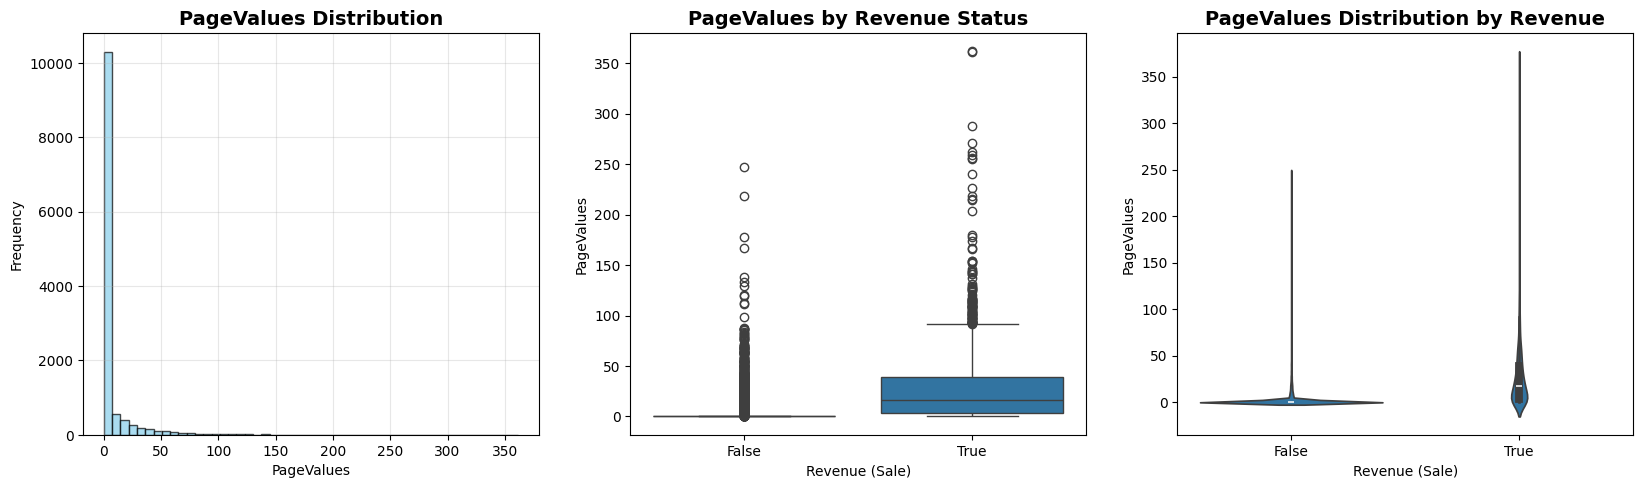

In [9]:
fig = plt.figure(figsize=(20, 24))
print(f"\n=== PAGEVALUES ANALYSIS ===")

# Basic statistics
pagevalues_stats = peoplewatcher['PageValues'].describe()
print("PageValues Statistics:")
print(pagevalues_stats)

# Correlation with Revenue
pagevalues_corr = peoplewatcher['PageValues'].corr(peoplewatcher['Revenue'].astype(int))
print(f"Correlation with Revenue: {pagevalues_corr:.4f}")

# Plot 1: PageValues 
plt.subplot(4, 3, 1)
plt.hist(peoplewatcher['PageValues'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('PageValues Distribution', fontsize=14, fontweight='bold')
plt.xlabel('PageValues')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 2: PageValues by Revenue (Box Plot)
plt.subplot(4, 3, 2)
sns.boxplot(data=peoplewatcher, x='Revenue', y='PageValues')
plt.title('PageValues by Revenue Status', fontsize=14, fontweight='bold')
plt.xlabel('Revenue (Sale)')
plt.ylabel('PageValues')

# Plot 3: PageValues by Revenue (Violin Plot)
plt.subplot(4, 3, 3)
sns.violinplot(data=peoplewatcher, x='Revenue', y='PageValues')
plt.title('PageValues Distribution by Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Revenue (Sale)')
plt.ylabel('PageValues')

In [10]:
#Prediction Examples based on Page Values
def predict_purchase_likelihood(PageValues, product_visits=1, month='Jan', visitor_type='Returning_Visitor'):
    """
    Predict purchase likelihood based on time spent on PageValues
    """
    # Create a sample row with your input
    sample_data = pd.DataFrame({
        'ProductRelated': [product_visits],
        'PageValues': [PageValues],
        'Month': [month],
        'VisitorType': [visitor_type]
    })

    sample_encoded = pd.get_dummies(sample_data, columns=["Month", "VisitorType"])
    
    # Ensure all columns match training data
    for col in X.columns:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0
    
    sample_encoded = sample_encoded[X.columns] 
    
    sample_scaled = scaler.transform(sample_encoded)
    probability = base_model.predict_proba(sample_scaled)[0][1]
    
    return probability

# Example predictions based on PageValues
print(f"\n=== EXAMPLE PREDICTIONS (PageValues Focus) ===")
print(f"PageValues=30: {predict_purchase_likelihood(30)*100:.1f}% purchase probability")
print(f"PageValues=120: {predict_purchase_likelihood(120)*100:.1f}% purchase probability")
print(f"PageValues=200: {predict_purchase_likelihood(200)*100:.1f}% purchase probability")
print(f"PageValues=400: {predict_purchase_likelihood(400)*100:.1f}% purchase probability")


=== EXAMPLE PREDICTIONS (PageValues Focus) ===
PageValues=30: 85.2% purchase probability
PageValues=120: 85.6% purchase probability
PageValues=200: 85.6% purchase probability
PageValues=400: 85.6% purchase probability


In [11]:
values_correlation = peoplewatcher['PageValues'].corr(peoplewatcher['Revenue'].astype(int))
print(f"\nCorrelation between PageValues and Revenue: {values_correlation:.4f}")

if values_correlation > 0:
    print("✓ Higher Averages of pages vistied IS associated with higher purchase likelihood")
else:
    print("✗ Higher Averages of pages vistied shows negative association with purchases")

# Also analyze visit count for comparison
print("\n=== COMPARISON: VISITS vs TIME SPENT vs PAGEVALUES ===")
visit_correlation = peoplewatcher['ProductRelated'].corr(peoplewatcher['Revenue'].astype(int))
duration_correlation = peoplewatcher['ProductRelated_Duration'].corr(peoplewatcher['Revenue'].astype(int))
print(f"PageValue correlation: {values_correlation:.4f}")
print(f"ProductRelated visits correlation: {visit_correlation:.4f}")
print(f"ProductRelated duration correlation: {duration_correlation:.4f}")

if abs(values_correlation) > abs(visit_correlation) and abs(values_correlation) > abs(duration_correlation):
    print("✓ PAGE VALUE is the strongest predictor")
elif abs(duration_correlation) > abs(visit_correlation):
    print("✓ TIME SPENT is a stronger predictor than visit count")
else:
    print("✓ VISIT COUNT is the strongest predictor")
    


Correlation between PageValues and Revenue: 0.4926
✓ Higher Averages of pages vistied IS associated with higher purchase likelihood

=== COMPARISON: VISITS vs TIME SPENT vs PAGEVALUES ===
PageValue correlation: 0.4926
ProductRelated visits correlation: 0.1585
ProductRelated duration correlation: 0.1524
✓ PAGE VALUE is the strongest predictor


In [12]:
value_row = feature_importance[feature_importance['feature'] == 'PageValues']
feature_rank = value_row['rank'].iloc[0]
feature_value = value_row['importance'].iloc[0]
print(f"\n" + "="*60)
print("ANSWER TO YOUR RESEARCH QUESTION")
print("="*60)
print(f"Question: Do more page visits increase purchase likelihood?")
print(f"Answer: {'YES' if values_correlation > 0 else 'NO'}")
print(f"Evidence:")
print(f"- Visit correlation: {values_correlation:.4f}")
print(f"- Feature importance: PageValues ranks #{feature_rank} out of {len(feature_importance)} (importance: {feature_value:.6f})")
print(f"- Model accuracy: {accuracy*100:.2f}% (Target: 75%)")


ANSWER TO YOUR RESEARCH QUESTION
Question: Do more page visits increase purchase likelihood?
Answer: YES
Evidence:
- Visit correlation: 0.4926
- Feature importance: PageValues ranks #1 out of 26 (importance: 0.421941)
- Model accuracy: 89.42% (Target: 75%)


Product Related Duration Analysis


=== PRODUCTRELATED_DURATION ANALYSIS ===
ProductRelated_Duration Statistics:
count    12330.000000
mean      1194.746220
std       1913.669288
min          0.000000
25%        184.137500
50%        598.936905
75%       1464.157214
max      63973.522230
Name: ProductRelated_Duration, dtype: float64
Correlation with Revenue: 0.1524


Text(0, 0.5, 'ProductRelated_Duration (seconds)')

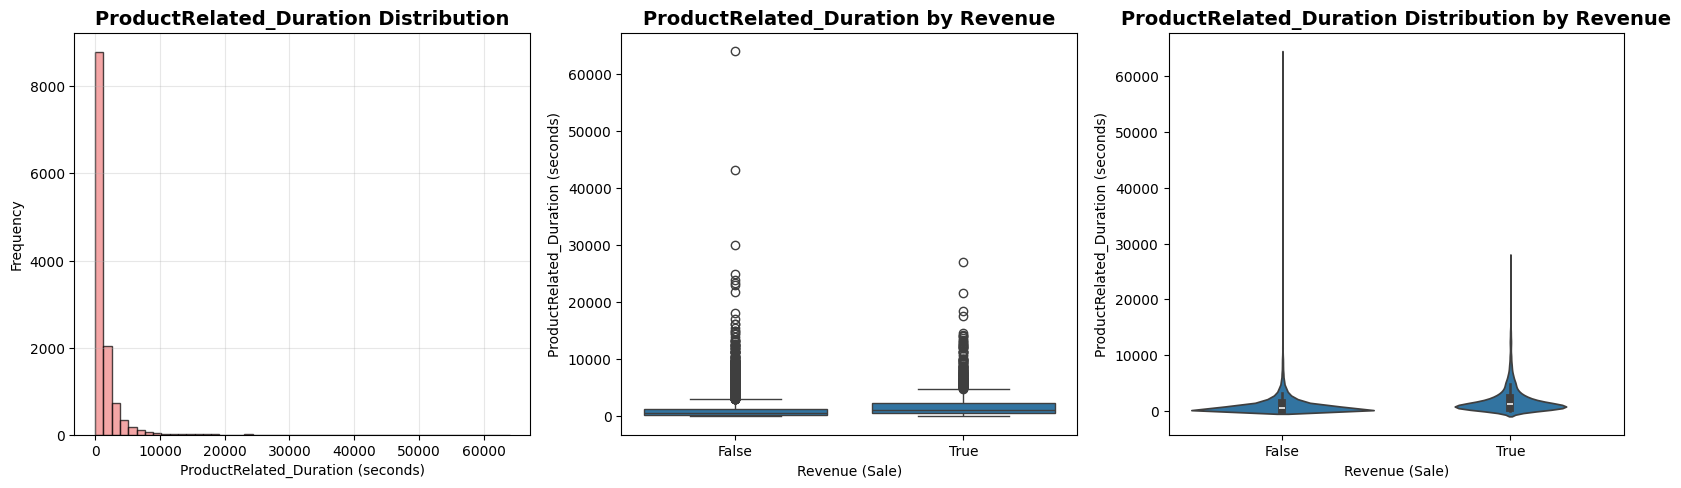

In [13]:
fig = plt.figure(figsize=(20, 24))
print(f"\n=== PRODUCTRELATED_DURATION ANALYSIS ===")

# Basic statistics
duration_stats = peoplewatcher['ProductRelated_Duration'].describe()
print("ProductRelated_Duration Statistics:")
print(duration_stats)

# Correlation with Revenue
duration_corr = peoplewatcher['ProductRelated_Duration'].corr(peoplewatcher['Revenue'].astype(int))
print(f"Correlation with Revenue: {duration_corr:.4f}")

# Plot 4: ProductRelated_Duration Distribution
plt.subplot(4, 3, 4)
plt.hist(peoplewatcher['ProductRelated_Duration'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('ProductRelated_Duration Distribution', fontsize=14, fontweight='bold')
plt.xlabel('ProductRelated_Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 5: ProductRelated_Duration by Revenue (Box Plot)
plt.subplot(4, 3, 5)
sns.boxplot(data=peoplewatcher, x='Revenue', y='ProductRelated_Duration')
plt.title('ProductRelated_Duration by Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Revenue (Sale)')
plt.ylabel('ProductRelated_Duration (seconds)')

# Plot 6: ProductRelated_Duration by Revenue (Violin Plot)
plt.subplot(4, 3, 6)
sns.violinplot(data=peoplewatcher, x='Revenue', y='ProductRelated_Duration')
plt.title('ProductRelated_Duration Distribution by Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Revenue (Sale)')
plt.ylabel('ProductRelated_Duration (seconds)')

In [14]:
#Prediction Examples based on Time Spent on Product Duration Page
def predict_purchase_likelihood(product_duration, product_visits=1, month='Jan', visitor_type='Returning_Visitor'):
    """
    Predict purchase likelihood based on time spent on ProductRelated pages
    """
    # Create a sample row with your input
    sample_data = pd.DataFrame({
        'ProductRelated': [product_visits],
        'ProductRelated_Duration': [product_duration],
        'Month': [month],
        'VisitorType': [visitor_type]
    })

    sample_encoded = pd.get_dummies(sample_data, columns=["Month", "VisitorType"])
    
    # Ensure all columns match training data
    for col in X.columns:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0
    
    sample_encoded = sample_encoded[X.columns] 
    
    sample_scaled = scaler.transform(sample_encoded)
    probability = base_model.predict_proba(sample_scaled)[0][1]
    
    return probability

# Example predictions based on time spent
print(f"\n=== EXAMPLE PREDICTIONS (Time Spent Focus) ===")
print(f"30 seconds on ProductRelated pages: {predict_purchase_likelihood(30)*100:.1f}% purchase probability")
print(f"120 seconds on ProductRelated pages: {predict_purchase_likelihood(120)*100:.1f}% purchase probability")
print(f"300 seconds on ProductRelated pages: {predict_purchase_likelihood(300)*100:.1f}% purchase probability")
print(f"600 seconds on ProductRelated pages: {predict_purchase_likelihood(600)*100:.1f}% purchase probability")


=== EXAMPLE PREDICTIONS (Time Spent Focus) ===
30 seconds on ProductRelated pages: 12.9% purchase probability
120 seconds on ProductRelated pages: 13.0% purchase probability
300 seconds on ProductRelated pages: 13.1% purchase probability
600 seconds on ProductRelated pages: 12.1% purchase probability


In [15]:
duration_correlation = peoplewatcher['ProductRelated_Duration'].corr(peoplewatcher['Revenue'].astype(int))
print(f"\nCorrelation between ProductRelated_Duration (time spent) and Revenue: {duration_correlation:.4f}")

if duration_correlation > 0:
    print("✓ More time on ProductRelated pages IS associated with higher purchase likelihood")
else:
    print("✗ Time on ProductRelated pages shows negative association with purchases")

# Also analyze visit count for comparison
print("\n=== COMPARISON: VISITS vs TIME SPENT ===")
visit_correlation = peoplewatcher['ProductRelated'].corr(peoplewatcher['Revenue'].astype(int))
print(f"ProductRelated visits correlation: {visit_correlation:.4f}")
print(f"ProductRelated duration correlation: {duration_correlation:.4f}")

if abs(duration_correlation) > abs(visit_correlation):
    print("✓ TIME SPENT is a stronger predictor than visit count")
else:
    print("✓ VISIT COUNT is a stronger predictor than time spent")


Correlation between ProductRelated_Duration (time spent) and Revenue: 0.1524
✓ More time on ProductRelated pages IS associated with higher purchase likelihood

=== COMPARISON: VISITS vs TIME SPENT ===
ProductRelated visits correlation: 0.1585
ProductRelated duration correlation: 0.1524
✓ VISIT COUNT is a stronger predictor than time spent


In [16]:
productduration_row = feature_importance[feature_importance['feature'] == 'ProductRelated_Duration']
feature_rank = feature_ranks['ProductRelated_Duration']
feature_value = productduration_row['importance'].iloc[0]
print(f"\n" + "="*60)
print("ANSWER TO YOUR RESEARCH QUESTION")
print("="*60)
print(f"Question: Does more time spent on ProductRelated pages increase purchase likelihood?")
print(f"Answer: {'YES' if duration_correlation > 0 else 'NO'}")
print(f"Evidence:")
print(f"- Duration correlation: {duration_correlation:.4f}")
print(f"- Feature importance: ProductRelated_Duration ranks #{feature_rank} out of {len(feature_importance)} (importance: {feature_value:.6f})")
print(f"- Visits correlation: {visit_correlation:.4f} (for comparison)")
print(f"- Model accuracy: {accuracy*100:.2f}% (Target: 75%)")


ANSWER TO YOUR RESEARCH QUESTION
Question: Does more time spent on ProductRelated pages increase purchase likelihood?
Answer: YES
Evidence:
- Duration correlation: 0.1524
- Feature importance: ProductRelated_Duration ranks #3 out of 26 (importance: 0.088578)
- Visits correlation: 0.1585 (for comparison)
- Model accuracy: 89.42% (Target: 75%)


Product Page Visits to Sales Likelihood


=== PRODUCTRELATED ANALYSIS ===
ProductRelated Statistics:
count    12330.000000
mean        31.731468
std         44.475503
min          0.000000
25%          7.000000
50%         18.000000
75%         38.000000
max        705.000000
Name: ProductRelated, dtype: float64
Correlation with Revenue: 0.1585


Text(0, 0.5, 'ProductRelated (page count)')

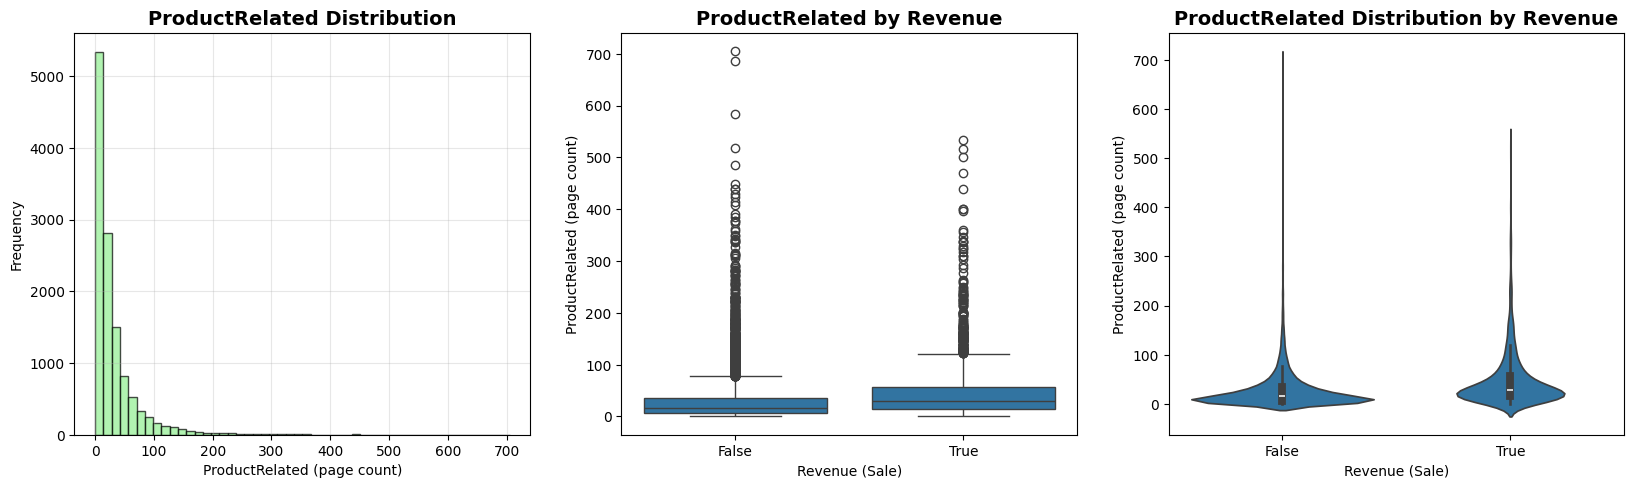

In [17]:
fig = plt.figure(figsize=(20, 24))
print(f"\n=== PRODUCTRELATED ANALYSIS ===")

# Basic statistics
related_stats = peoplewatcher['ProductRelated'].describe()
print("ProductRelated Statistics:")
print(related_stats)

# Correlation with Revenue
related_corr = peoplewatcher['ProductRelated'].corr(peoplewatcher['Revenue'].astype(int))
print(f"Correlation with Revenue: {related_corr:.4f}")

# Plot 7: ProductRelated Distribution
plt.subplot(4, 3, 7)
plt.hist(peoplewatcher['ProductRelated'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('ProductRelated Distribution', fontsize=14, fontweight='bold')
plt.xlabel('ProductRelated (page count)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 8: ProductRelated by Revenue (Box Plot)
plt.subplot(4, 3, 8)
sns.boxplot(data=peoplewatcher, x='Revenue', y='ProductRelated')
plt.title('ProductRelated by Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Revenue (Sale)')
plt.ylabel('ProductRelated (page count)')

# Plot 9: ProductRelated by Revenue (Violin Plot)
plt.subplot(4, 3, 9)
sns.violinplot(data=peoplewatcher, x='Revenue', y='ProductRelated')
plt.title('ProductRelated Distribution by Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Revenue (Sale)')
plt.ylabel('ProductRelated (page count)')

In [18]:
correlation = peoplewatcher['ProductRelated'].corr(peoplewatcher['Revenue'].astype(int))
print(f"\nCorrelation between ProductRelated visits and Revenue: {correlation:.4f}")
if correlation > 0:
    print("✓ More ProductRelated visits ARE associated with higher purchase likelihood")
else:
    print("✗ ProductRelated visits show negative association with purchases")


Correlation between ProductRelated visits and Revenue: 0.1585
✓ More ProductRelated visits ARE associated with higher purchase likelihood


In [19]:
productrelated_row = feature_importance[feature_importance['feature'] == 'ProductRelated']
feature_rank = feature_ranks['ProductRelated']
feature_value = productrelated_row['importance'].iloc[0]

print(f"\n" + "="*60)
print("ANSWER TO YOUR RESEARCH QUESTION")
print("="*60)
print(f"Question: Do more ProductRelated page visits increase purchase likelihood?")
print(f"Answer: {'YES' if correlation > 0 else 'NO'}")
print(f"Evidence:")
print(f"- Correlation coefficient: {correlation:.4f}")
print(f"- Feature importance: ProductRelated ranks #{feature_rank} out of {len(feature_importance)} (importance: {feature_value:.6f})")
print(f"- Model accuracy: {accuracy*100:.2f}% (Target: 75%)")


ANSWER TO YOUR RESEARCH QUESTION
Question: Do more ProductRelated page visits increase purchase likelihood?
Answer: YES
Evidence:
- Correlation coefficient: 0.1585
- Feature importance: ProductRelated ranks #4 out of 26 (importance: 0.064609)
- Model accuracy: 89.42% (Target: 75%)


In [20]:
# Prediction function for new data
def predict_purchase_likelihood(product_related_visits, product_duration=0, special_day=0, month='Jan', visitor_type='Returning_Visitor'):
    """
    Predict purchase likelihood based on ProductRelated visits
    """
    # Create a sample row with your input
    sample_data = pd.DataFrame({
        'ProductRelated': [product_related_visits],
        'ProductRelated_Duration': [product_duration],
        'SpecialDay': [special_day],
        'Month': [month],
        'VisitorType': [visitor_type]
    })
    
    # Apply same encoding as training data
    sample_encoded = pd.get_dummies(sample_data, columns=["Month", "VisitorType"])
    
    # Ensure all columns match training data
    for col in X.columns:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0
    
    sample_encoded = sample_encoded[X.columns]  # Reorder columns
    
    # Scale and predict
    sample_scaled = scaler.transform(sample_encoded)
    probability = base_model.predict_proba(sample_scaled)[0][1]
    
    return probability

# Example predictions
print(f"\n=== EXAMPLE PREDICTIONS ===")
print(f"5 ProductRelated visits: {predict_purchase_likelihood(5)*100:.1f}% purchase probability")
print(f"15 ProductRelated visits: {predict_purchase_likelihood(15)*100:.1f}% purchase probability")
print(f"30 ProductRelated visits: {predict_purchase_likelihood(30)*100:.1f}% purchase probability")


=== EXAMPLE PREDICTIONS ===
5 ProductRelated visits: 14.1% purchase probability
15 ProductRelated visits: 10.6% purchase probability
30 ProductRelated visits: 11.4% purchase probability


In [21]:
duration_rank = feature_ranks['ProductRelated_Duration']
duration_importance = feature_importance[feature_importance['feature'] == 'ProductRelated_Duration']['importance'].values[0]

# Get PageValues (Average Visits) for comparison
values_rank = feature_ranks['PageValues'] 
values_importance = feature_importance[feature_importance['feature'] == 'PageValues']['importance'].values[0]

# Also get ProductRelated (visits) for comparison
visits_rank = feature_ranks['ProductRelated']
visits_importance = feature_importance[feature_importance['feature'] == 'ProductRelated']['importance'].values[0]

print(f"\nProductRelated_Duration (Time Spent) Analysis:")
print(f"- Rank: #{duration_rank} out of {len(feature_importance)} features")
print(f"- Importance Score: {duration_importance:.4f}")

print(f"\nProductRelated (Visits) Analysis:")
print(f"- Rank: #{visits_rank} out of {len(feature_importance)} features") 
print(f"- Importance Score: {visits_importance:.4f}")

print(f"\nPageValues (Average Visits) Analysis:")
print(f"- Rank: #{values_rank} out of {len(feature_importance)} features") 
print(f"- Importance Score: {values_importance:.4f}")

# print(f"\n{'TIME SPENT' if duration_importance > visits_importance else 'VISIT COUNT'} is more important for predictions")
if abs(values_correlation) > abs(visit_correlation) and abs(values_correlation) > abs(duration_correlation):
    print(f"\n✓ PAGE VALUE is the strongest predictor")
elif abs(duration_correlation) > abs(visit_correlation):
    print(f"\n✓ TIME SPENT is a stronger predictor than visit count")
else:
    print(f"\n✓ VISIT COUNT is the strongest predictor")


ProductRelated_Duration (Time Spent) Analysis:
- Rank: #3 out of 26 features
- Importance Score: 0.0886

ProductRelated (Visits) Analysis:
- Rank: #4 out of 26 features
- Importance Score: 0.0646

PageValues (Average Visits) Analysis:
- Rank: #1 out of 26 features
- Importance Score: 0.4219

✓ PAGE VALUE is the strongest predictor


Correlation Matrix Of Key Features to Revenue

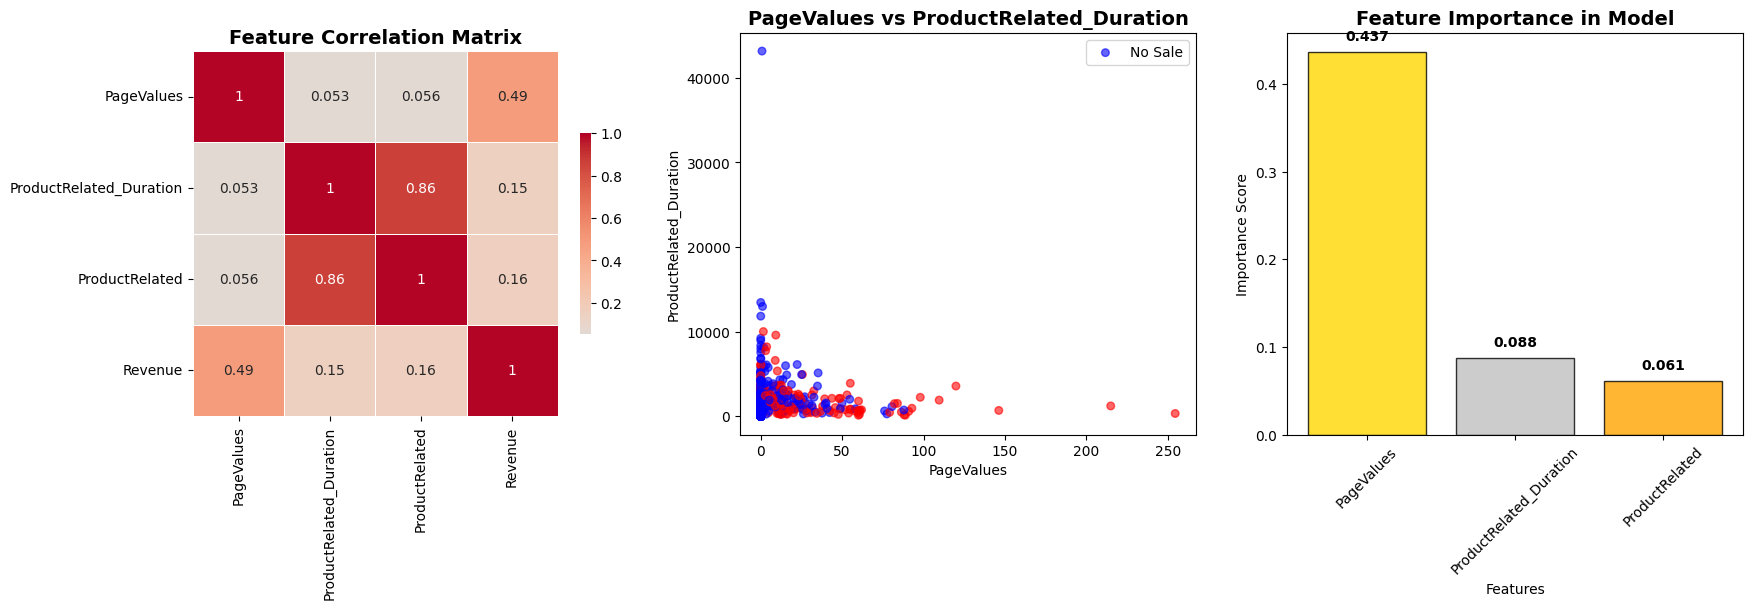

In [22]:
# Plot 10: Correlation Matrix
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 10)
correlation_data = peoplewatcher[key_features + ['Revenue']].corr()
mask = np.triu(np.ones_like(correlation_data, dtype=bool))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Plot 11: Scatter Plot Matrix
plt.subplot(4, 3, 11)
# Create binned scatter plot for PageValues vs ProductRelated_Duration
scatter_data = peoplewatcher.sample(n=min(1000, len(peoplewatcher)))  # Sample for readability
colors = ['red' if x else 'blue' for x in scatter_data['Revenue']]
plt.scatter(scatter_data['PageValues'], scatter_data['ProductRelated_Duration'], 
           c=colors, alpha=0.6, s=30)
plt.title('PageValues vs ProductRelated_Duration', fontsize=14, fontweight='bold')
plt.xlabel('PageValues')
plt.ylabel('ProductRelated_Duration')
plt.legend(['No Sale', 'Sale'], loc='upper right')

# Plot 12: Feature Importance Bar Chart (from your model)
plt.subplot(4, 3, 12)
importance_values = [0.437033, 0.087690, 0.061123]  # Your provided importance values
colors_bar = ['gold', 'silver', 'orange']
bars = plt.bar(key_features, importance_values, color=colors_bar, alpha=0.8, edgecolor='black')
plt.title('Feature Importance in Model', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, importance_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')


plt.show()


Detailed Analysis Diving Deeper

In [23]:
print(f"\n" + "="*60)
print("DETAILED STATISTICAL ANALYSIS")
print("="*60)

# Sales vs No Sales comparison for each feature
for feature in key_features:
    print(f"\n--- {feature.upper()} ANALYSIS ---")
    
    # Separate data by revenue
    sale_data = peoplewatcher[peoplewatcher['Revenue'] == True][feature]
    no_sale_data = peoplewatcher[peoplewatcher['Revenue'] == False][feature]
    
    print(f"Sales Group - Mean: {sale_data.mean():.4f}, Median: {sale_data.median():.4f}")
    print(f"No Sales Group - Mean: {no_sale_data.mean():.4f}, Median: {no_sale_data.median():.4f}")
    
    # Statistical significance test
    t_stat, p_value = stats.ttest_ind(sale_data, no_sale_data, nan_policy='omit')
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")
    
    if p_value < 0.05:
        print(f"✓ SIGNIFICANT difference between groups (p < 0.05)")
    else:
        print(f"✗ No significant difference between groups (p >= 0.05)")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(sale_data) - 1) * sale_data.var() + 
                         (len(no_sale_data) - 1) * no_sale_data.var()) / 
                        (len(sale_data) + len(no_sale_data) - 2))
    cohens_d = (sale_data.mean() - no_sale_data.mean()) / pooled_std
    print(f"Effect Size (Cohen's d): {cohens_d:.4f}")
    
    if abs(cohens_d) >= 0.8:
        print("✓ LARGE effect size")
    elif abs(cohens_d) >= 0.5:
        print("✓ MEDIUM effect size")
    elif abs(cohens_d) >= 0.2:
        print("✓ SMALL effect size")
    else:
        print("✗ Negligible effect size")


DETAILED STATISTICAL ANALYSIS

--- PAGEVALUES ANALYSIS ---
Sales Group - Mean: 27.2645, Median: 16.7581
No Sales Group - Mean: 1.9760, Median: 0.0000
T-test: t-statistic = 62.8432, p-value = 0.000000
✓ SIGNIFICANT difference between groups (p < 0.05)
Effect Size (Cohen's d): 1.5649
✓ LARGE effect size

--- PRODUCTRELATED_DURATION ANALYSIS ---
Sales Group - Mean: 1876.2096, Median: 1109.9062
No Sales Group - Mean: 1069.9878, Median: 510.1900
T-test: t-statistic = 17.1180, p-value = 0.000000
✓ SIGNIFICANT difference between groups (p < 0.05)
Effect Size (Cohen's d): 0.4263
✓ SMALL effect size

--- PRODUCTRELATED ANALYSIS ---
Sales Group - Mean: 48.2102, Median: 29.0000
No Sales Group - Mean: 28.7146, Median: 16.0000
T-test: t-statistic = 17.8282, p-value = 0.000000
✓ SIGNIFICANT difference between groups (p < 0.05)
Effect Size (Cohen's d): 0.4439
✓ SMALL effect size



FEATURE BINNING ANALYSIS

--- PAGEVALUES CONVERSION RATES BY BIN ---
Very Low: 14.45% conversion rate (12149.0 samples)
Low: 84.31% conversion rate (153.0 samples)
Medium: 86.67% conversion rate (15.0 samples)
High: 81.82% conversion rate (11.0 samples)
Very High: 100.00% conversion rate (2.0 samples)

--- PRODUCTRELATED_DURATION CONVERSION RATES BY BIN ---
Very Low: 15.41% conversion rate (12294.0 samples)
Low: 37.50% conversion rate (32.0 samples)
Medium: 50.00% conversion rate (2.0 samples)
High: 0.00% conversion rate (1.0 samples)
Very High: 0.00% conversion rate (1.0 samples)

--- PRODUCTRELATED CONVERSION RATES BY BIN ---
Very Low: 14.87% conversion rate (11982.0 samples)
Low: 35.89% conversion rate (287.0 samples)
Medium: 38.30% conversion rate (47.0 samples)
High: 45.45% conversion rate (11.0 samples)
Very High: 0.00% conversion rate (3.0 samples)


C:\Users\Valky\AppData\Local\Temp\ipykernel_10964\2772493408.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rates = peoplewatcher.groupby(f'{feature}_binned')['Revenue'].agg(['mean', 'count'])
C:\Users\Valky\AppData\Local\Temp\ipykernel_10964\2772493408.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conversion_rates = peoplewatcher.groupby(f'{feature}_binned')['Revenue'].agg(['mean', 'count'])
C:\Users\Valky\AppData\Local\Temp\ipykernel_10964\2772493408.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obser

<Figure size 2000x2400 with 0 Axes>

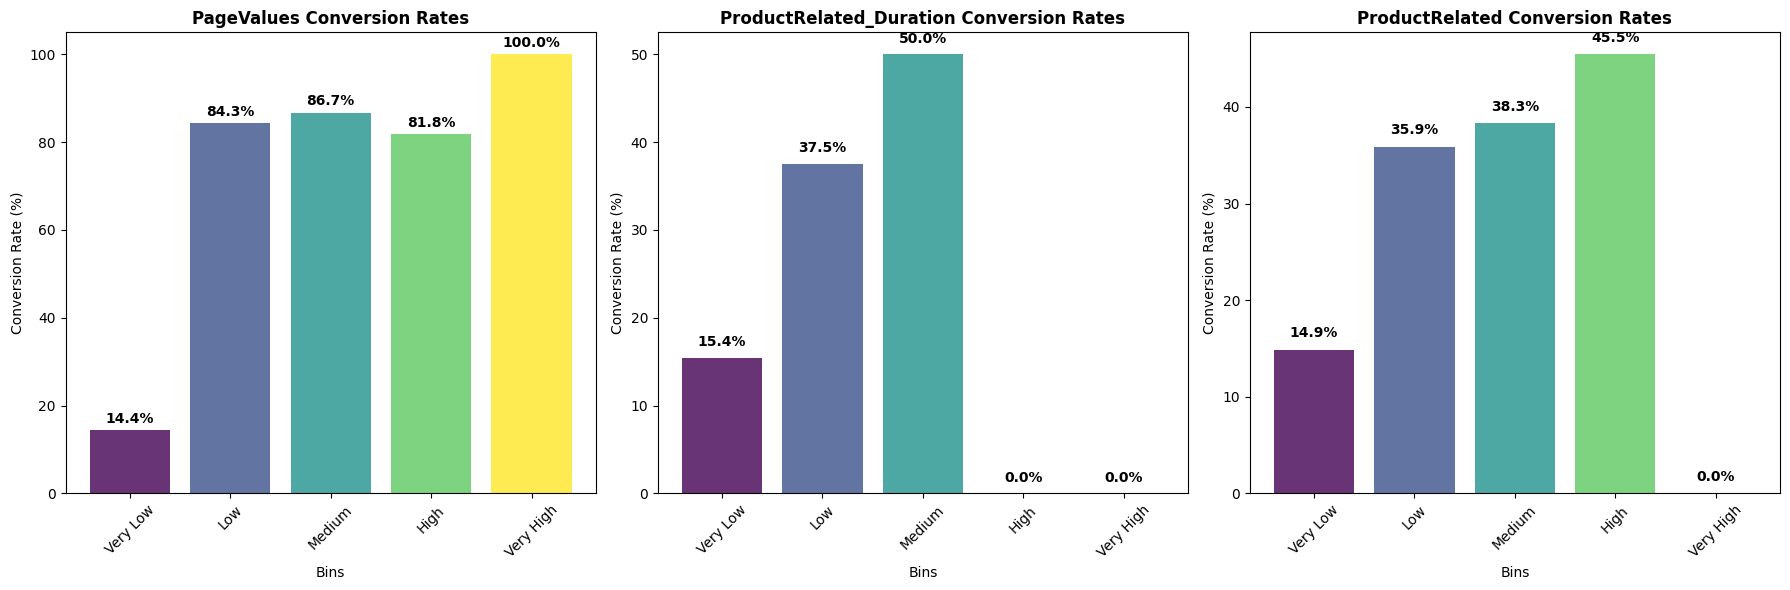

In [24]:
fig = plt.figure(figsize=(20, 24))
print(f"\n" + "="*60)
print("FEATURE BINNING ANALYSIS")
print("="*60)

# Create a summary figure for binned analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, feature in enumerate(key_features):
    # Create bins for the feature
    peoplewatcher[f'{feature}_binned'] = pd.cut(peoplewatcher[feature], 
                                               bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    # Calculate conversion rate by bin
    conversion_rates = peoplewatcher.groupby(f'{feature}_binned')['Revenue'].agg(['mean', 'count'])
    conversion_rates['mean'] = conversion_rates['mean'] * 100  # Convert to percentage
    
    print(f"\n--- {feature.upper()} CONVERSION RATES BY BIN ---")
    for bin_name, row in conversion_rates.iterrows():
        print(f"{bin_name}: {row['mean']:.2f}% conversion rate ({row['count']} samples)")
    
    # Plot conversion rates
    axes[idx].bar(range(len(conversion_rates)), conversion_rates['mean'], 
                  color=plt.cm.viridis(np.linspace(0, 1, len(conversion_rates))), alpha=0.8)
    axes[idx].set_title(f'{feature} Conversion Rates', fontweight='bold')
    axes[idx].set_xlabel('Bins')
    axes[idx].set_ylabel('Conversion Rate (%)')
    axes[idx].set_xticks(range(len(conversion_rates)))
    axes[idx].set_xticklabels(conversion_rates.index, rotation=45)
    
    # Add value labels on bars
    for i, rate in enumerate(conversion_rates['mean']):
        axes[idx].text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Best Model Possible

In [25]:
#Check Base Model Accuracy before Optimization
accuracy = accuracy_score(y_test, base_pred)
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

if accuracy >= 0.75:
    print("✓ TARGET ACHIEVED: Model exceeds 75% accuracy!")
else:
    print("✗ Target not met. Try different parameters.")

print(f"\nDetailed Results:")
print(classification_report(y_test, base_pred))


Model Accuracy: 0.8942 (89.42%)
✓ TARGET ACHIEVED: Model exceeds 75% accuracy!

Detailed Results:
              precision    recall  f1-score   support

       False       0.93      0.94      0.94      2084
        True       0.66      0.64      0.65       382

    accuracy                           0.89      2466
   macro avg       0.80      0.79      0.79      2466
weighted avg       0.89      0.89      0.89      2466




RANDOM FOREST MODEL TRAINING
Features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'OperatingSystems', 'Region', 'TrafficType', 'Weekend', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Other', 'VisitorType_Returning_Visitor']
Class distribution: {0: 10422, 1: 1908}

🎯 MODEL RESULTS:
Accuracy: 0.8889 (88.89%)
✅ SUCCESS: Model exceeds 75.0% accuracy target!

Detailed Results:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2084
           1       0.63      0.69      0.66       382

    accuracy                           0.89      2466
   macro avg       0.79      0.81      0.80      2466
weighted avg       0.89      0.89      0.89      2466



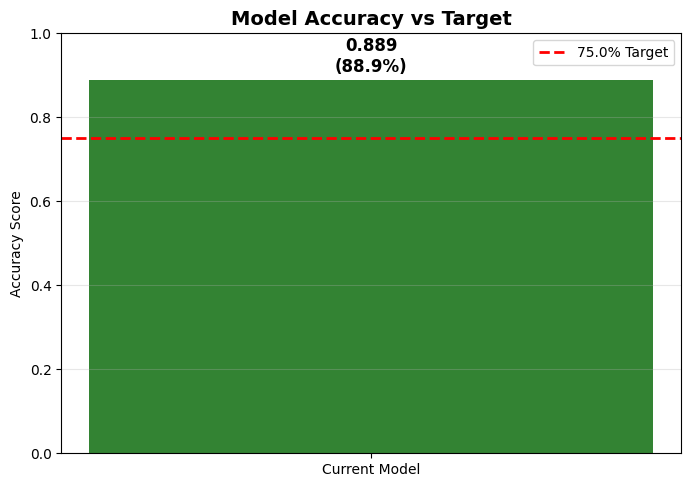

In [26]:
# Train RandomForest Model
print("\n" + "="*50)
print("RANDOM FOREST MODEL TRAINING")
print("="*50)

target_accuracy= 0.75

# Prepare features and target
X = rockwall.drop('Revenue', axis=1)
y = rockwall['Revenue']
    
print(f"Features: {list(X.columns)}")
print(f"Class distribution: {y.value_counts().to_dict()}")
    
    
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
    
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
# Train RandomForest
first_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
    
first_model.fit(X_train_scaled, y_train)
    
# Make predictions
first_pred = first_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, first_pred)
    
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': first_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🎯 MODEL RESULTS:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
if accuracy >= target_accuracy:
    print(f"✅ SUCCESS: Model exceeds {target_accuracy*100}% accuracy target!")
else:
    print(f"❌ Model below {target_accuracy*100}% target. Consider tuning.")
    
print(f"\nDetailed Results:")
print(classification_report(y_test, first_pred))
    
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
models = ['Current Model']
accuracies = [accuracy]
target = [target_accuracy]
    
bars = plt.bar(models, accuracies, color='darkgreen' if accuracy >= target_accuracy else 'orange', alpha=0.8)
plt.axhline(y=target_accuracy, color='red', linestyle='--', linewidth=2, label=f'{target_accuracy*100}% Target')
    
plt.text(0, accuracy + 0.01, f'{accuracy:.3f}\n({accuracy*100:.1f}%)', 
            ha='center', va='bottom', fontweight='bold', fontsize=12)
    
plt.title('Model Accuracy vs Target', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()



RANDOM FOREST MODEL TRAINING
Features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'OperatingSystems', 'Region', 'TrafficType', 'Weekend', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Other', 'VisitorType_Returning_Visitor']
Class distribution: {0: 10422, 1: 1908}

🚀 Training RandomForest model...

🎯 MODEL RESULTS:
Accuracy: 0.9015 (90.15%)
✅ SUCCESS: Model exceeds 75.0% accuracy target!

Detailed Results:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2084
           1       0.72      0.60      0.66       382

    accuracy                           0.90      2466
   macro avg       0.82      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466



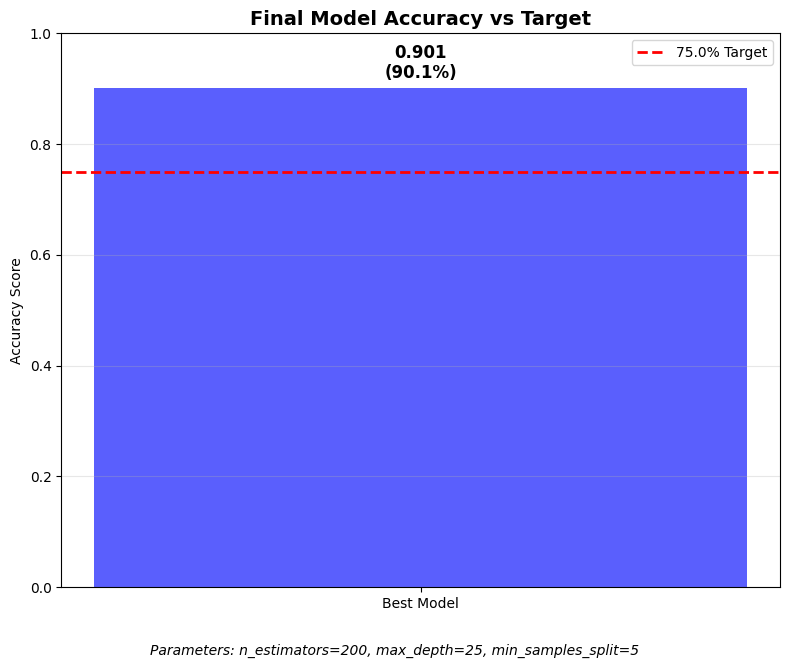

In [27]:
# Train RandomForest Model
print("\n" + "="*50)
print("RANDOM FOREST MODEL TRAINING")
print("="*50)

target_accuracy= 0.75

# Prepare features and target
X = rockwall.drop('Revenue', axis=1)
y = rockwall['Revenue']
    
print(f"Features: {list(X.columns)}")
print(f"Class distribution: {y.value_counts().to_dict()}")
    
    
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
    
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=5,
    random_state=50,
    class_weight='balanced'  # Handle class imbalance
)

print("\n🚀 Training RandomForest model...")
best_model.fit(X_train_scaled, y_train)

best_pred = best_model.predict(X_test_scaled)
best_pred_proba = best_model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, best_pred)
print(f"\n🎯 MODEL RESULTS:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
if accuracy >= target_accuracy:
    print(f"✅ SUCCESS: Model exceeds {target_accuracy*100}% accuracy target!")
else:
    print(f"❌ Model below {target_accuracy*100}% target. Consider tuning.")

print(f"\nDetailed Results:")
print(classification_report(y_test, best_pred))

plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)

models = ['Best Model']
accuracies = [accuracy]
target = [target_accuracy]
    
bars = plt.bar(models, accuracies, color='#3137fd' if accuracy >= target_accuracy else 'orange', alpha=0.8)
plt.axhline(y=target_accuracy, color='red', linestyle='--', linewidth=2, label=f'{target_accuracy*100}% Target')
    
plt.text(0, accuracy + 0.01, f'{accuracy:.3f}\n({accuracy*100:.1f}%)', 
         ha='center', va='bottom', fontweight='bold', fontsize=12)
    
plt.title('Final Model Accuracy vs Target', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Optional: Add model parameters as subtitle
plt.figtext(0.5, 0.45, f'Parameters: n_estimators=200, max_depth=25, min_samples_split=5',
           ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()


RANDOM FOREST MODEL COMPARISON


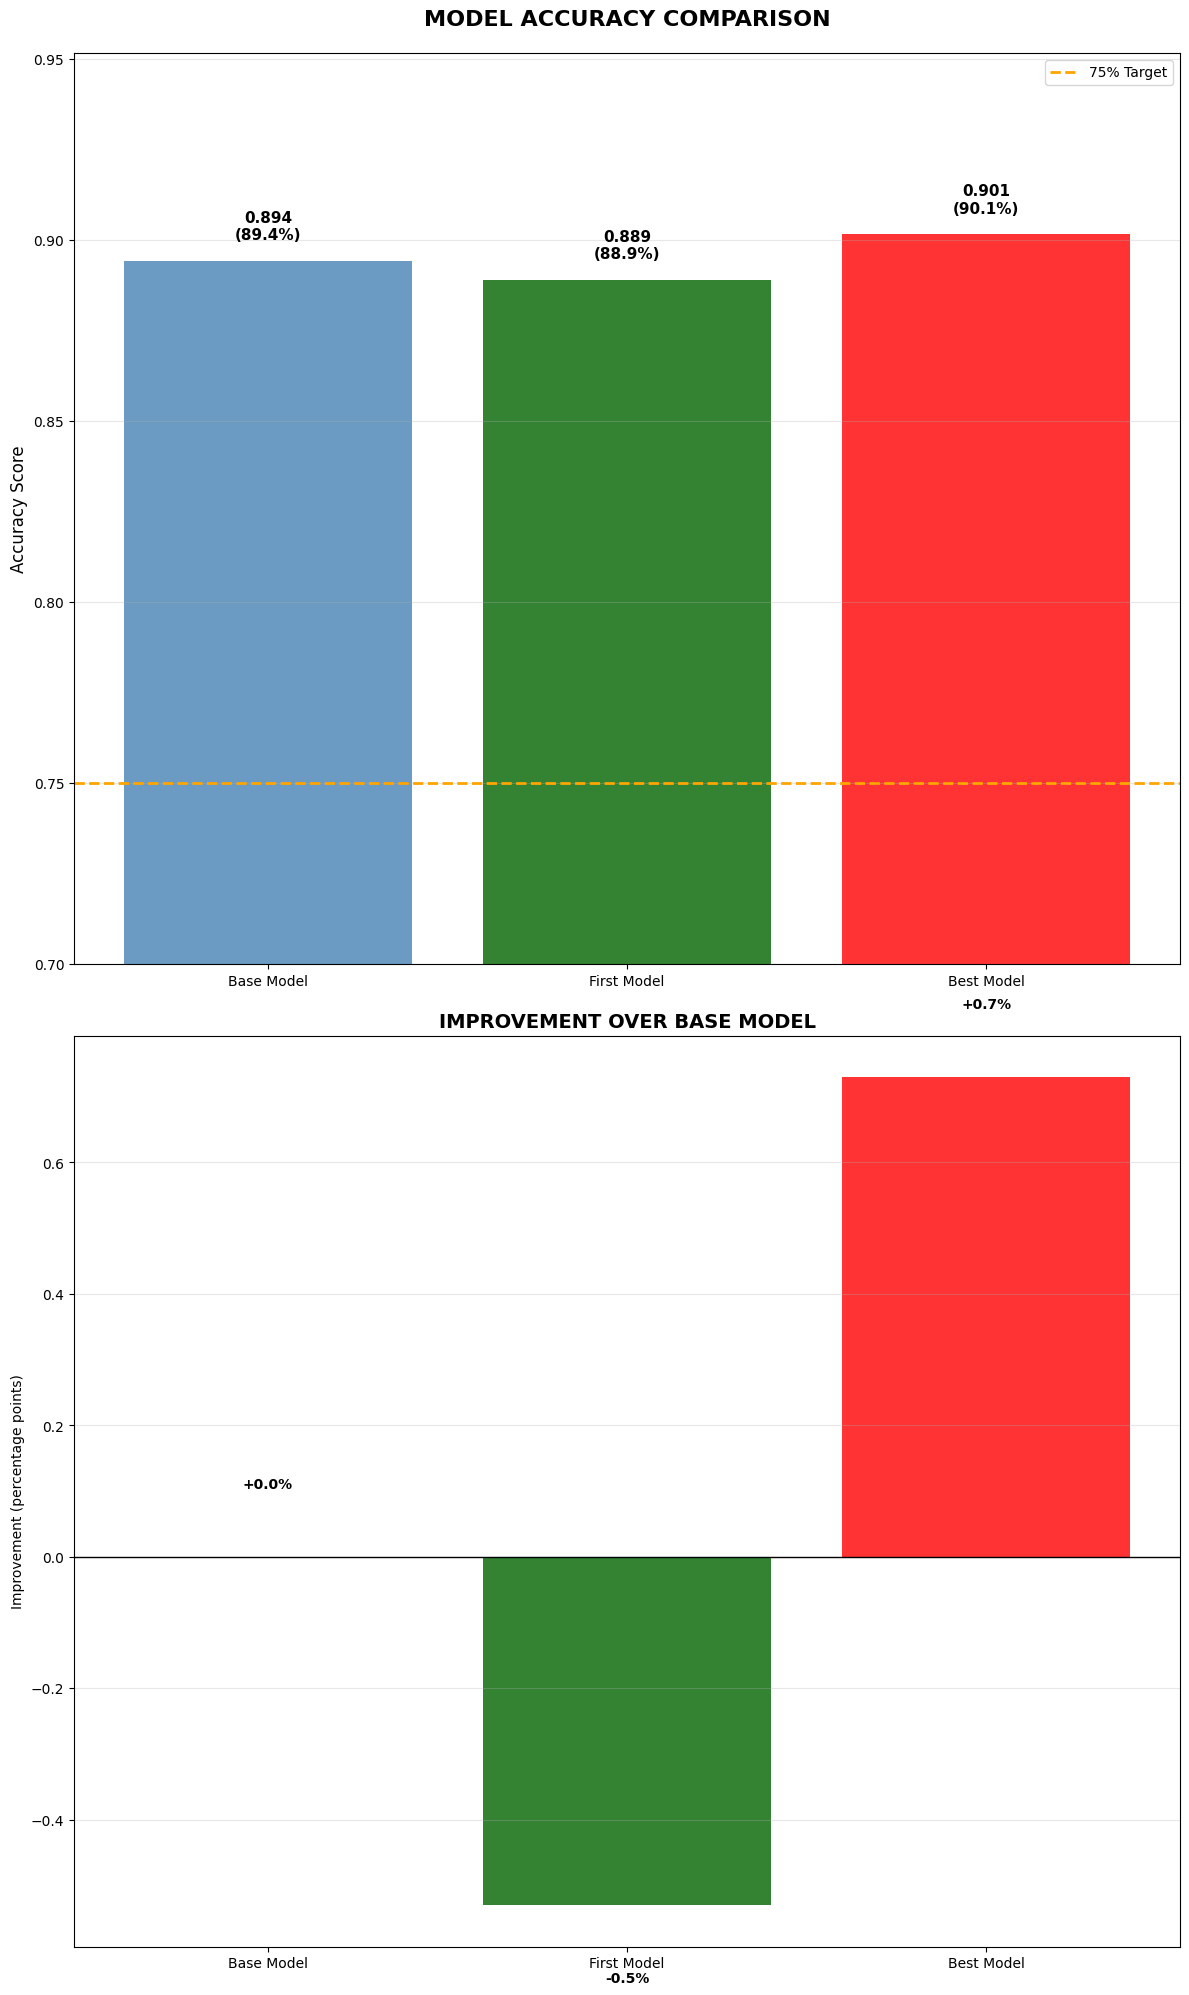


📊 ROCKWALL MODEL RESULTS:
Base Model: 0.8942 (89.42%) ✅ GOOD
First Model: 0.8889 (88.89%) ✅ GOOD
Best Model: 0.9015 (90.15%) 🏆 BEST

🎯 TARGET ANALYSIS:
Target Accuracy: 75%
- Base Model: Exceeds target by 14.4 percentage points
- First Model: Exceeds target by 13.9 percentage points
- Best Model: Exceeds target by 15.1 percentage points

FINAL ROCKWALL MODEL COMPARISON SUMMARY
🏆 Best Model: Best Model with 90.1% accuracy
📈 Total Improvement: 1.3 percentage points
✅ All models exceed 75% target requirement
🎉 SUCCESS: All models meet performance standards!


In [28]:
# Model Comparisons

#Accuracy variables
base_model_accuracy = 0.8942
first_model_accuracy = 0.8889 
best_model_accuracy = 0.9015 

# Model comparison data 
model_results = {
    'Model': ['Base Model', 'First Model', 'Best Model'],
    'Accuracy': [base_model_accuracy, first_model_accuracy, best_model_accuracy],
    'Target': [0.75, 0.75, 0.75]  # Target accuracy line
}

rockwall_results = pd.DataFrame(model_results)

# Model Accuracy Comparison (matching your style)
print("\n" + "="*50)
print("RANDOM FOREST MODEL COMPARISON")
print("="*50)

plt.figure(figsize=(12, 20))

# Main accuracy comparison plot
plt.subplot(2, 1, 1)
colors = ['steelblue', 'darkgreen', 'red']  # Different color for best model
bars = plt.bar(rockwall_results['Model'], rockwall_results['Accuracy'], color=colors, alpha=0.8)

# Add target line
plt.axhline(y=0.75, color='orange', linestyle='--', linewidth=2, label='75% Target')

# Add value labels on bars
for bar, acc in zip(bars, rockwall_results['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.3f}\n({acc*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title('MODEL ACCURACY COMPARISON', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy Score', fontsize=12)
plt.ylim(0.7, max(rockwall_results['Accuracy']) + 0.05)  # Dynamic y-limit
plt.grid(axis='y', alpha=0.3)
plt.legend()

# Performance improvement visualization
plt.subplot(2, 1, 2)
baseline_acc = rockwall_results['Accuracy'].iloc[0]  # Use first model as baseline
improvement = [(acc - baseline_acc) * 100 for acc in rockwall_results['Accuracy']]
colors_imp = ['gray', 'darkgreen', 'red']
bars = plt.bar(rockwall_results['Model'], improvement, color=colors_imp, alpha=0.8)

plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Add value labels
for bar, imp in zip(bars, improvement):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 0.1 if imp >= 0 else bar.get_height() - 0.1,
             f'+{imp:.1f}%' if imp >= 0 else f'{imp:.1f}%',
             ha='center', va='bottom' if imp >= 0 else 'top', fontweight='bold')

plt.title('IMPROVEMENT OVER BASE MODEL', fontsize=14, fontweight='bold')
plt.ylabel('Improvement (percentage points)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Results summary (matching your print style)
print(f"\n📊 ROCKWALL MODEL RESULTS:")
best_model_row = rockwall_results.loc[rockwall_results['Accuracy'].idxmax()]

for idx, row in rockwall_results.iterrows():
    status = "🏆 BEST" if row['Model'] == best_model_row['Model'] else "✅ GOOD"
    print(f"{row['Model']}: {row['Accuracy']:.4f} ({row['Accuracy']*100:.2f}%) {status}")

print(f"\n🎯 TARGET ANALYSIS:")
print(f"Target Accuracy: 75%")
for idx, row in rockwall_results.iterrows():
    exceed = (row['Accuracy'] - 0.75) * 100
    print(f"- {row['Model']}: Exceeds target by {exceed:.1f} percentage points")

print(f"\n" + "="*60)
print("FINAL ROCKWALL MODEL COMPARISON SUMMARY")
print("="*60)
print(f"🏆 Best Model: {best_model_row['Model']} with {best_model_row['Accuracy']*100:.1f}% accuracy")
print(f"📈 Total Improvement: {(rockwall_results['Accuracy'].max() - rockwall_results['Accuracy'].min())*100:.1f} percentage points")

# Check if all models exceed target
all_exceed = all(acc >= 0.75 for acc in rockwall_results['Accuracy'])
if all_exceed:
    print(f"✅ All models exceed 75% target requirement")
    print(f"🎉 SUCCESS: All models meet performance standards!")
else:
    print(f"⚠️  Some models below 75% target - review performance")


COMPREHENSIVE MODEL COMPARISON

📊 DETAILED METRICS COMPARISON:
      Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
 Base Model    0.8942     0.8925  0.8942    0.8933      NaN
First Model    0.8889     0.8932  0.8889    0.8908      NaN
 Best Model    0.9015     0.8963  0.9015    0.8980   0.9237


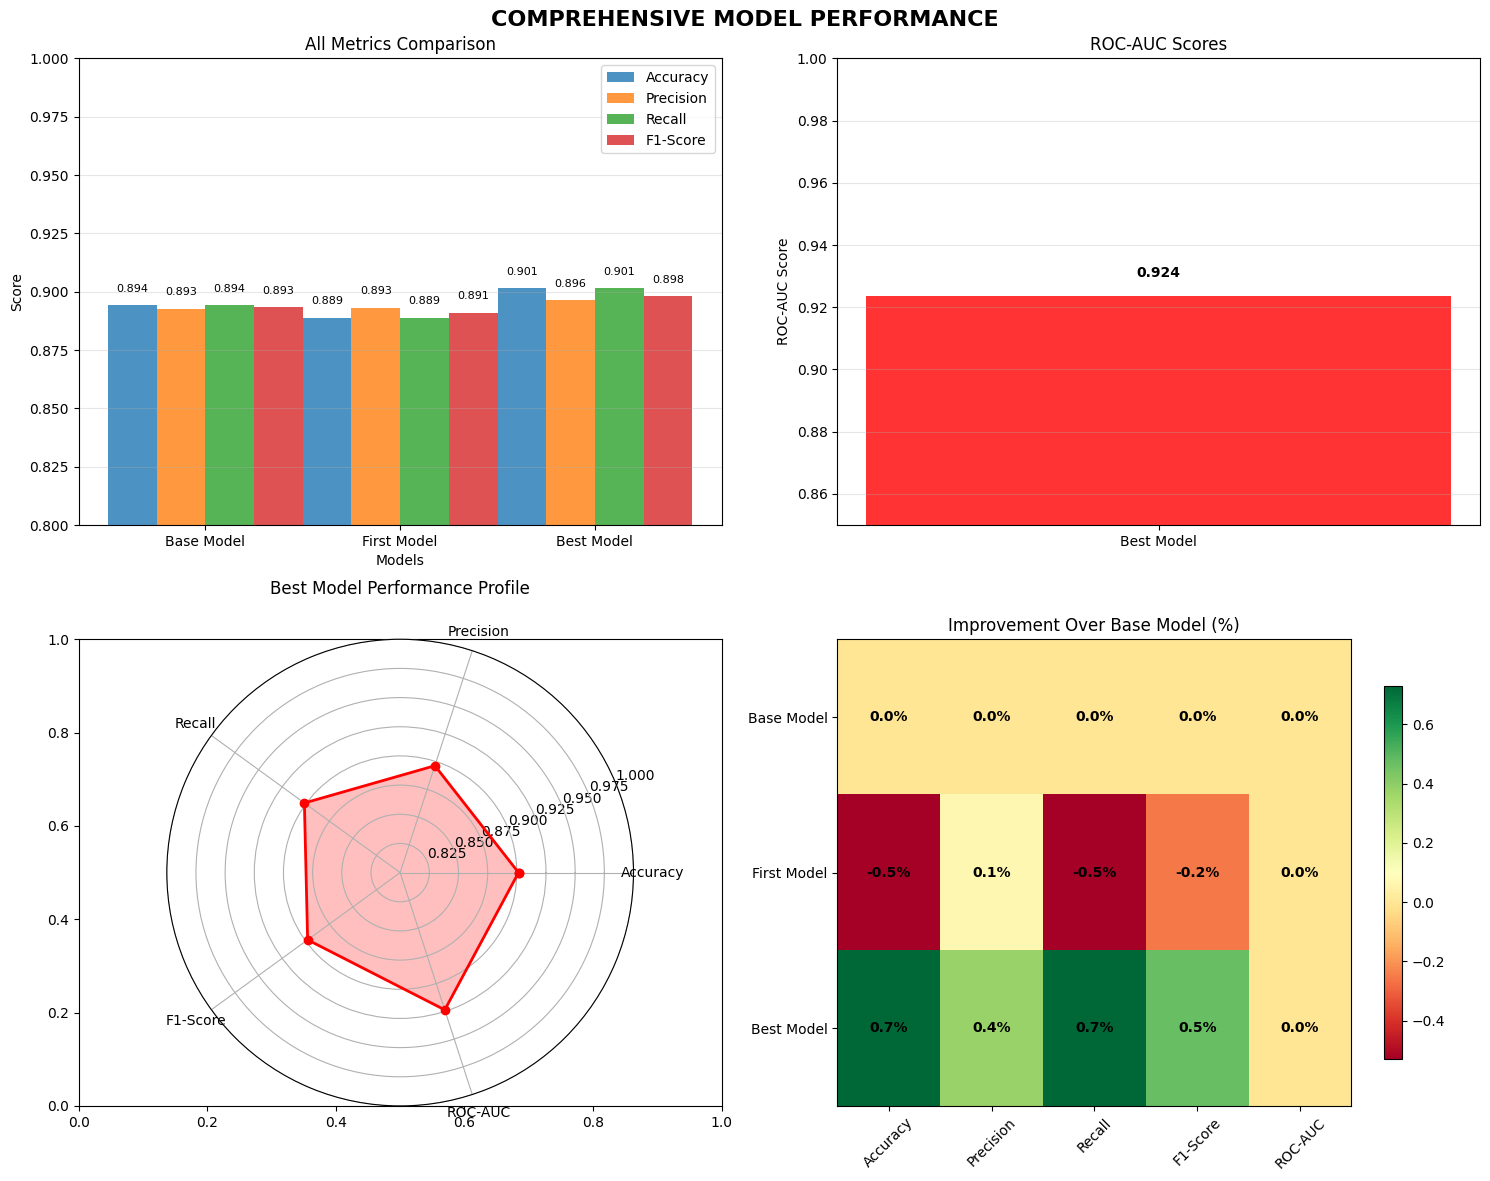


🏆 BEST PERFORMERS BY METRIC:
- Accuracy: Best Model (0.9015)
- Precision: Best Model (0.8963)
- Recall: Best Model (0.9015)
- F1-Score: Best Model (0.8980)
- ROC-AUC: Best Model (0.9237)

📈 IMPROVEMENT ANALYSIS:

First Model vs Base Model:
  - Accuracy: -0.5 percentage points
  - Precision: +0.1 percentage points
  - Recall: -0.5 percentage points
  - F1-Score: -0.2 percentage points
  - ROC-AUC: +nan percentage points

Best Model vs Base Model:
  - Accuracy: +0.7 percentage points
  - Precision: +0.4 percentage points
  - Recall: +0.7 percentage points
  - F1-Score: +0.5 percentage points
  - ROC-AUC: +nan percentage points

ONLINE SHOPPING MODEL RECOMMENDATION
🎯 RECOMMENDED MODEL: Best Model
📊 Average Score: 0.9042
💡 This model provides the best balance across all metrics

✅ TARGET ACHIEVEMENT:
- Accuracy (≥0.75): Base Model, First Model, Best Model
- Precision (≥0.80): Base Model, First Model, Best Model
- Recall (≥0.75): Base Model, First Model, Best Model
- F1-Score (≥0.75): Base

In [29]:
# Function to calculate all metrics for a model
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate comprehensive metrics for model evaluation"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted')
    }
    
    # Add ROC-AUC if probabilities are available
    if y_pred_proba is not None:
        if len(np.unique(y_true)) == 2:  # Binary classification
            metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba[:, 1])
        else:  # Multi-class
            metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
    
    return metrics

# Example: Calculate metrics for your models
# Replace these with your actual model predictions:

# For Base Model
base_metrics = calculate_metrics(y_test, base_pred)

# For First Model  
first_metrics = calculate_metrics(y_test, first_pred)

# For Best Model
best_metrics = calculate_metrics(y_test, best_pred, best_pred_proba)


# Create comprehensive results DataFrame
comprehensive_results = pd.DataFrame({
    'Model': ['Base Model', 'First Model', 'Best Model'],
    'Accuracy': [base_metrics['accuracy'], first_metrics['accuracy'], best_metrics['accuracy']],
    'Precision': [base_metrics['precision'], first_metrics['precision'], best_metrics['precision']],
    'Recall': [base_metrics['recall'], first_metrics['recall'], best_metrics['recall']],
    'F1-Score': [base_metrics['f1_score'], first_metrics['f1_score'], best_metrics['f1_score']],
    'ROC-AUC': [base_metrics.get('roc_auc', None), first_metrics.get('roc_auc', None), best_metrics.get('roc_auc', None)]
})

print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Display metrics table
print("\n📊 DETAILED METRICS COMPARISON:")
print(comprehensive_results.round(4).to_string(index=False))

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('COMPREHENSIVE MODEL PERFORMANCE', fontsize=16, fontweight='bold')

# Metrics to plot (excluding ROC-AUC for separate treatment)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'darkgreen', 'red']

# Plot 1: All main metrics comparison
ax1 = axes[0, 0]
x = np.arange(len(comprehensive_results))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    bars = ax1.bar(x + i*width, comprehensive_results[metric], width, 
                   label=metric, alpha=0.8)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('All Metrics Comparison')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(comprehensive_results['Model'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0.8, 1.0)

# Plot 2: ROC-AUC specific comparison
ax2 = axes[0, 1]
bars = ax2.bar(comprehensive_results['Model'], comprehensive_results['ROC-AUC'], 
               color=colors, alpha=0.8)

for bar, score in zip(bars, comprehensive_results['ROC-AUC']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('ROC-AUC Scores')
ax2.set_ylabel('ROC-AUC Score')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0.85, 1.0)

# Plot 3: Radar chart for best model
available_metrics = []
best_model_scores = []

for metric in metrics_to_plot:
    available_metrics.append(metric)
    best_model_scores.append(best_metrics[metric.lower().replace('-', '_')])

# Add ROC-AUC if available for best model
if 'roc_auc' in best_metrics:
    available_metrics.append('ROC-AUC')
    best_model_scores.append(best_metrics['roc_auc'])

if len(available_metrics) > 0:
    angles = np.linspace(0, 2 * np.pi, len(available_metrics), endpoint=False)
    best_model_scores += best_model_scores[:1]  # Complete the circle
    angles = np.concatenate((angles, [angles[0]]))

    ax3 = plt.subplot(2, 2, 3, projection='polar')
    ax3.plot(angles, best_model_scores, 'o-', linewidth=2, label='Best Model', color='red')
    ax3.fill(angles, best_model_scores, alpha=0.25, color='red')
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(available_metrics)
    ax3.set_ylim(0.8, 1.0)
    ax3.set_title('Best Model Performance Profile', y=1.08)
    ax3.grid(True)

# Plot 4: Improvement heatmap
ax4 = axes[1, 1]
available_metric_cols = [col for col in comprehensive_results.columns[1:] if not comprehensive_results[col].isna().all()]
baseline_scores = comprehensive_results.iloc[0][available_metric_cols].values  # Base model scores
improvement_matrix = []

for i, row in comprehensive_results.iterrows():
    improvements = []
    for col in available_metric_cols:
        if pd.notna(row[col]) and pd.notna(comprehensive_results.iloc[0][col]):
            improvement = (row[col] - comprehensive_results.iloc[0][col]) * 100
            improvements.append(round(improvement, 2))
        else:
            improvements.append(0.0)  # No improvement if data missing
    improvement_matrix.append(improvements)

im = ax4.imshow(improvement_matrix, cmap='RdYlGn', aspect='auto')
ax4.set_xticks(range(len(available_metric_cols)))
ax4.set_xticklabels(available_metric_cols, rotation=45)
ax4.set_yticks(range(len(comprehensive_results)))
ax4.set_yticklabels(comprehensive_results['Model'])
ax4.set_title('Improvement Over Base Model (%)')

# Add text annotations
for i in range(len(comprehensive_results)):
    for j in range(len(available_metric_cols)):
        text = ax4.text(j, i, f'{improvement_matrix[i][j]:.1f}%',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax4, shrink=0.8)
plt.tight_layout()
plt.show()

# Detailed analysis
print(f"\n🏆 BEST PERFORMERS BY METRIC:")
for metric in metrics_to_plot + ['ROC-AUC']:
    best_idx = comprehensive_results[metric].idxmax()
    best_model = comprehensive_results.loc[best_idx, 'Model']
    best_score = comprehensive_results.loc[best_idx, metric]
    print(f"- {metric}: {best_model} ({best_score:.4f})")

print(f"\n📈 IMPROVEMENT ANALYSIS:")
baseline_row = comprehensive_results.iloc[0]
for i, row in comprehensive_results.iterrows():
    if i == 0:
        continue
    print(f"\n{row['Model']} vs Base Model:")
    for metric in metrics_to_plot + ['ROC-AUC']:
        improvement = (row[metric] - baseline_row[metric]) * 100
        print(f"  - {metric}: {improvement:+.1f} percentage points")

print(f"\n" + "="*70)
print("ONLINE SHOPPING MODEL RECOMMENDATION")
print("="*70)

# Overall best model 
overall_scores = comprehensive_results[metrics_to_plot + ['ROC-AUC']].mean(axis=1)
best_overall_idx = overall_scores.idxmax()
best_overall_model = comprehensive_results.loc[best_overall_idx, 'Model']

print(f"🎯 RECOMMENDED MODEL: {best_overall_model}")
print(f"📊 Average Score: {overall_scores.iloc[best_overall_idx]:.4f}")
print(f"💡 This model provides the best balance across all metrics")

# Target analysis for multiple metrics
targets = {'Accuracy': 0.75, 'Precision': 0.80, 'Recall': 0.75, 'F1-Score': 0.75, 'ROC-AUC': 0.85}
print(f"\n✅ TARGET ACHIEVEMENT:")
for metric, target in targets.items():
    models_meeting_target = comprehensive_results[comprehensive_results[metric] >= target]['Model'].tolist()
    print(f"- {metric} (≥{target:.2f}): {', '.join(models_meeting_target) if models_meeting_target else 'None'}")

In [30]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///peoplewatcher_processed.db')
rockwall.to_sql('shoppers_intentions', engine, if_exists='replace', index=False)

12330